In [ ]:
! pip install numba
import numba
from numba import cuda
from numba.cuda.cudadrv import enums
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import time
from numba import vectorize
import math

from google.colab import drive
drive.mount("/content/drive/")

params = {
    'figure.figsize': [15, 10],  # instead of 4.5, 4.5
    'axes.titlesize': 15,
    'axes.labelsize': 10,
    'axes.linewidth': 0.5,
    'font.size': 20,
    'font.family': 'monospace',
    #    'font.monospace': 'Alma Mono',
    'legend.fontsize': 15,
    'legend.loc': 'upper right',
    'legend.labelspacing': 0.25,
    # 'xtick.labelsize': 20,
    # 'ytick.labelsize': 20,
    'lines.linewidth': 3,
    'text.usetex': False,
    # 'figure.autolayout': True,
    'ytick.right': False,
    'xtick.top': False,

    'xtick.major.size': 5,
    'ytick.major.size': 5,
    'xtick.minor.size': 5,
    'ytick.minor.size': 5,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,

    'xtick.major.width': 2,
    'ytick.major.width': 2,
    'xtick.minor.width': 1,
    'ytick.minor.width': 1,

    'xtick.major.pad': 2,
    'ytick.major.pad': 2,
    # 'xtick.minor.pad': 14,
    # 'ytick.minor.pad': 14,

    'xtick.direction': 'inout',
    'ytick.direction': 'inout',

    'grid.linestyle': '-',         # solid
    'grid.linewidth': 1.5,        # in points
    'grid.alpha':     1,        # transparency, between 0.0 and 1.0
}
# plt.style.use('fivethirtyeight')
matplotlib.rcParams.update(params)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#LABWORK9 - HISTOGRAM
Data_path="/content/drive/MyDrive/HPC/"
Image_path=Data_path+"Test_org_3.jpg"
Image_path_2=Data_path+"Test_org_2.jpg"


# RGB to HSV
@cuda.jit
def grayscale(src, dst):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
  g = np.uint16((src[tidx,tidy, 0] + src[tidx,tidy, 1] + src[tidx,tidy, 2]) / 3)
  dst[tidx,tidy, 0] = dst[tidx,tidy, 1] = dst[tidx,tidy, 2] = g


# Image data
img_data=plt.imread(Image_path)

# Shape of the figure
(imageHeight,imageWidth,_)=img_data.shape
pixelCount = imageWidth * imageHeight
out_img = np.array(img_data, copy=True)


def compare(blockSize, option):
  #Grid size -> chunk
  #int to ensure it's an interger
  # BlockSize should be the multiplication of 32
  grid_1 = int(imageHeight/blockSize)
  grid_2 = int(imageWidth/blockSize)
  print(grid_1,grid_2)
  gridSize=(grid_1,grid_2)
  blockSize=(blockSize,blockSize)

  # Start timing
  start_time=time.time()

  # Copy image to the device from host(CPU)
  devSrc = cuda.to_device(img_data)

  # Allocate memory on the device (GPU)
  devDst = cuda.device_array((imageHeight,imageWidth,3), np.uint16)

  grayscale[gridSize,blockSize](devSrc, devDst)

  # Copy from device to host
  hostDst=devDst.copy_to_host()
  # Stop timing
  end_time=time.time()

  #Get the running time
  run_time=end_time-start_time

  if option == True:
    return run_time, hostDst
  else: return run_time



300 412
The run time is 0.36385178565979004 s
(1200, 1649, 3)


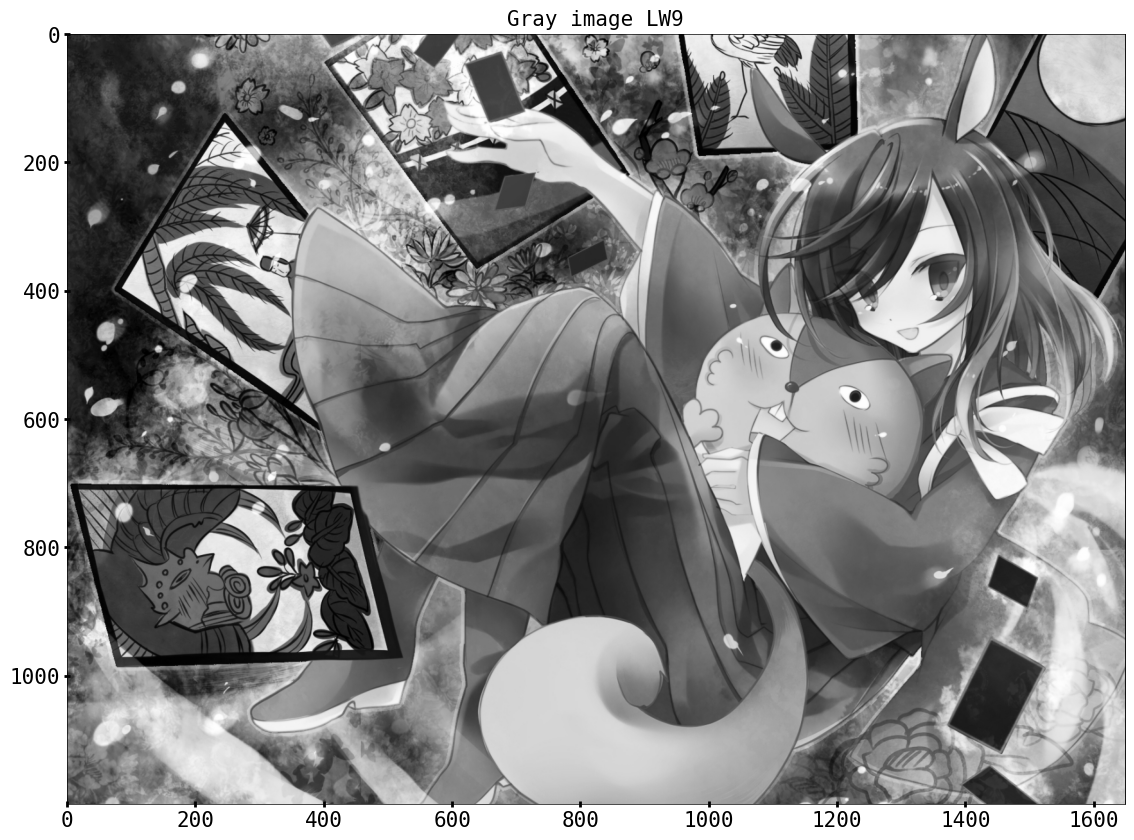

In [ ]:
#Output run_time and hostDst
blockSize = 4
run_time, hostDst= compare(blockSize,option=True)
plt.title("Gray image LW9")
plt.imshow(hostDst)
plt.savefig(Data_path+"Test_result_LW9_gray.jpg")
print("The run time is",run_time,"s")

print(hostDst.shape)

[ 32  42  50 ... 203 201   0]


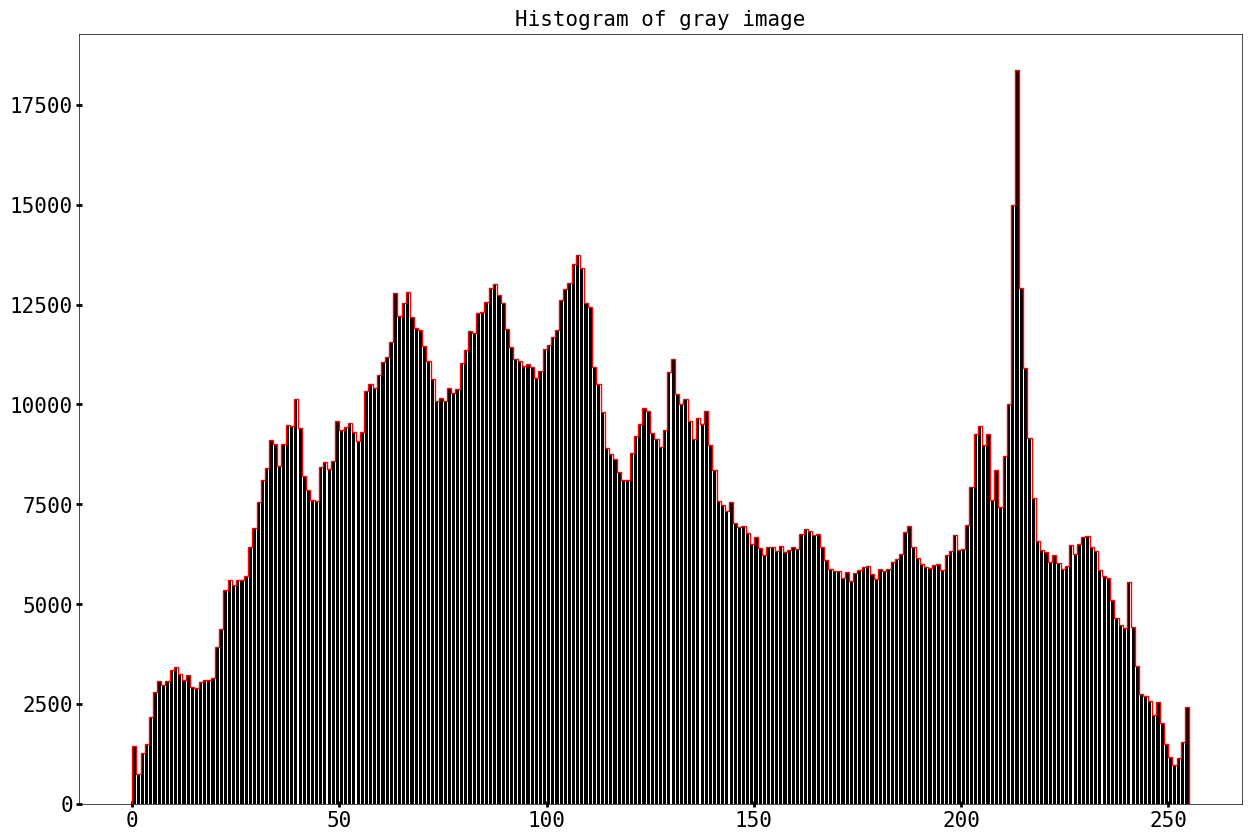

In [ ]:
img_data_gray = hostDst[:,:,0].flatten()
print(img_data_gray)
plt.title("Histogram of gray image")
plt.hist(img_data_gray,bins=range(256),color="k",histtype="bar",rwidth=0.75)
plt.hist(img_data_gray,bins=range(256),color="red",histtype="step")
plt.savefig("Histogram_LW9.jpg")